In [1]:
%matplotlib inline
import matplotlib
from madmex.wrappers import gwf_query
from datetime import datetime
import datetime as dt
import xarray as xr
import numpy as np
from madmex.util.xarray import to_float, to_int
from datacube.api import GridWorkflow

/usr/local/lib/python3.6/dist-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
2019-11-07 06:20:40,173 - madmex.wrappers - loggerwriter write: /usr/local/lib/python3.6/dist-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")
2019-11-07 06:20:40,174 - madmex.wrappers - loggerwriter write:   warnings.warn("The da.atop function has moved to da.blockwise")
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3141: PerformanceWarning: Increasing number of chunks by factor of 51
2019-11-07 06:21:07,715 - madmex.wrappers - loggerwriter write: /usr/local/lib/python3.6/dist-packages/dask/array/core.py:3141: PerformanceWarning: Increasing number of chunks by factor of 51
  **blockwise_kwargs)
2019-11-07 06:21:07,717 - madmex.wrappers - loggerwriter write:   **blockwise_kwargs)
/usr/local/lib/python3.6/dist-packages/dask/array/core.p

In [2]:
options = {}
#x = (-97.833251953125, -96.6522216796875)
x = (-97.833251953125,-97.4395751953125)
#y = (19.756364230752375, 20.648205934292623)
y = (20.5, 20.6)
options['lat'] = y
options['long'] = x
options['region'] = None
options['begin'] = "2019-01-1"
options['end'] = "2020-01-1"

In [3]:
name_of_product = 's2_l2a_10m_scl_mexico'

In [4]:
begin_time = datetime.strptime(options['begin'], '%Y-%m-%d')

In [5]:
gwf_kwargs = { k: options[k] for k in ['lat', 'long', 'region', 'begin', 'end']}
gwf_kwargs.update(product=name_of_product)
iterable = gwf_query(**gwf_kwargs)

In [6]:
len(iterable)

1

In [7]:
tile = list(iterable)[0]

In [8]:
sr_0 = xr.merge([GridWorkflow.load(tile[1], dask_chunks={'x': 100, 'y': 100},
                                   measurements=['red','nir','pixel_qa'])])

In [9]:
sr_0

<xarray.Dataset>
Dimensions:   (time: 10, x: 5002, y: 5002)
Coordinates:
  * time      (time) datetime64[ns] 2019-01-07T17:18:02 ... 2019-04-04T17:08:13.240000
  * y         (y) float64 9.761e+05 9.761e+05 9.761e+05 ... 9.261e+05 9.261e+05
  * x         (x) float64 2.928e+06 2.928e+06 2.928e+06 ... 2.978e+06 2.978e+06
Data variables:
    red       (time, y, x) uint16 dask.array<shape=(10, 5002, 5002), chunksize=(10, 100, 100)>
    nir       (time, y, x) uint16 dask.array<shape=(10, 5002, 5002), chunksize=(10, 100, 100)>
    pixel_qa  (time, y, x) uint16 dask.array<shape=(10, 5002, 5002), chunksize=(10, 100, 100)>

In [10]:
sr_0['ndvi'] = ((sr_0.nir-sr_0.red)/(sr_0.nir+sr_0.red))

In [11]:
matplotlib.rcParams['figure.figsize'] = [12, 8]

In [12]:
#sr_0.ndvi[0,:,:].plot()

In [13]:
begin_time - datetime.utcfromtimestamp(sr_0['time'][0].values.astype(datetime)*1e-9)

datetime.timedelta(-7, 24118)

In [14]:
# nearest in recent version has tolerance argument to limit nearest values. That could mean Na's but avoid values too far
ts_1 = sr_0.ndvi.resample(time='10D', 
                   loffset=begin_time - 
                   datetime.utcfromtimestamp(sr_0['time'][0].values.astype(datetime)*1e-9)).nearest().interpolate_na('time')

In [15]:
ts_1['time']

<xarray.DataArray 'time' (time: 9)>
array(['2019-01-01T00:00:00.000000000', '2019-01-11T00:00:00.000000000',
       '2019-01-21T00:00:00.000000000', '2019-01-31T00:00:00.000000000',
       '2019-02-10T00:00:00.000000000', '2019-02-20T00:00:00.000000000',
       '2019-03-02T00:00:00.000000000', '2019-03-12T00:00:00.000000000',
       '2019-03-22T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-01-11 ... 2019-03-22
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [16]:
ts_1

<xarray.DataArray 'ndvi' (time: 9, y: 5002, x: 5002)>
dask.array<shape=(9, 5002, 5002), dtype=float64, chunksize=(9, 100, 100)>
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-01-11 ... 2019-03-22
  * y        (y) float64 9.761e+05 9.761e+05 9.761e+05 ... 9.261e+05 9.261e+05
  * x        (x) float64 2.928e+06 2.928e+06 2.928e+06 ... 2.978e+06 2.978e+06

In [17]:
#ts_1[0,:,:].plot()

In [19]:
# interpolate_na throws an error due to chunking for parallelization. 
# Could be avoid if chunksize didn't split time dimension
ts_2 = sr_0.ndvi.resample(time='10D',
                   loffset=begin_time - 
                   datetime.utcfromtimestamp(sr_0['time'][0].values.astype(datetime)*1e-9)).max('time')#.interpolate_na('time')


In [20]:
ts_2

<xarray.DataArray 'ndvi' (time: 9, y: 5002, x: 5002)>
dask.array<shape=(9, 5002, 5002), dtype=float64, chunksize=(3, 100, 100)>
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-01-11 ... 2019-03-22
  * y        (y) float64 9.761e+05 9.761e+05 9.761e+05 ... 9.261e+05 9.261e+05
  * x        (x) float64 2.928e+06 2.928e+06 2.928e+06 ... 2.978e+06 2.978e+06

In [21]:
#ts_2[0,:,:].plot()

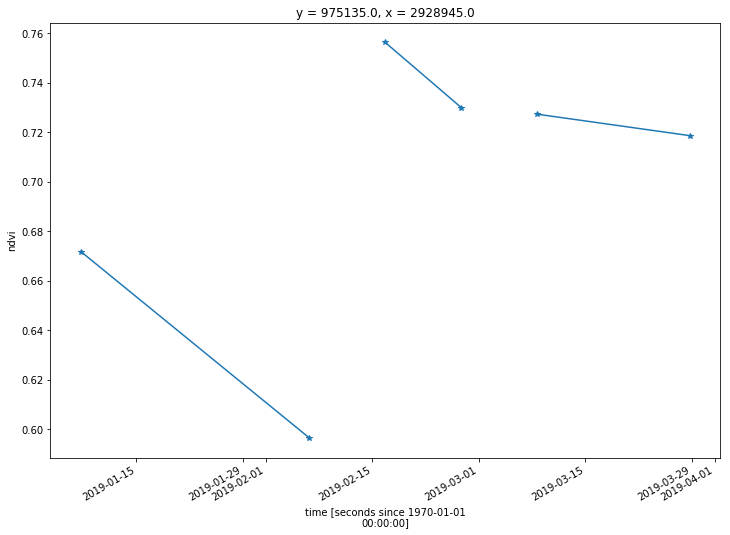

In [26]:
sr_0.ndvi[:,100,100].plot(marker="*")

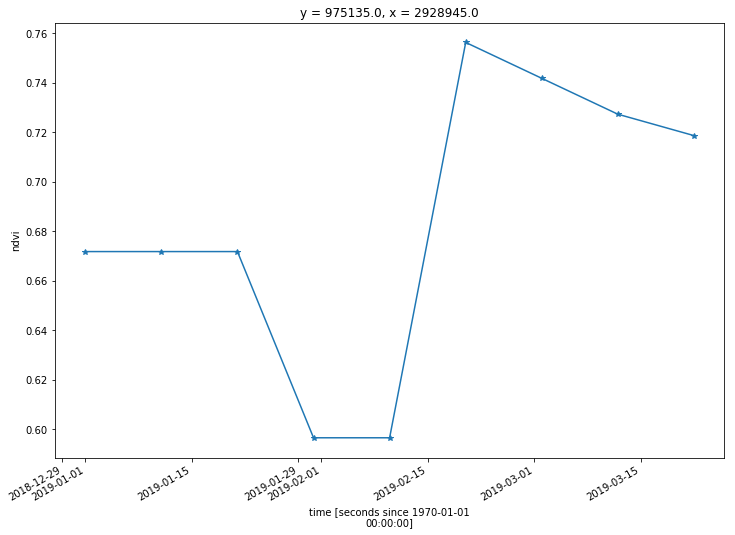

In [27]:
ts_1[:,100,100].plot(marker="*")

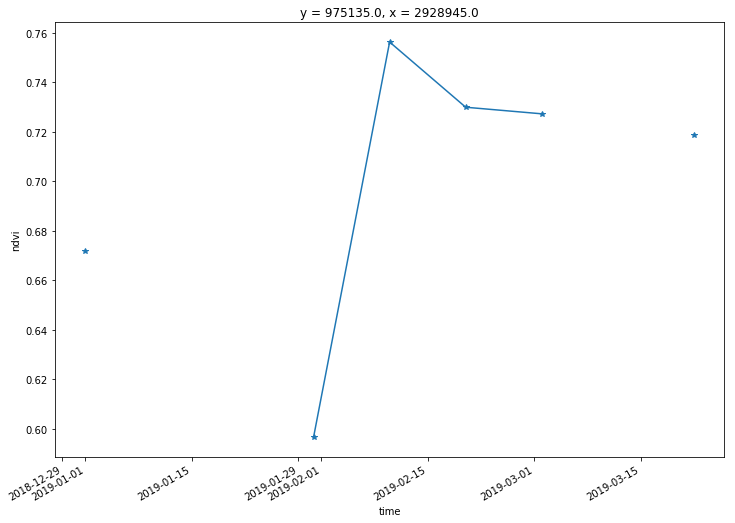

In [54]:
ts_2[:,100,100].plot(marker="*")

In [ ]:
#df = ts.to_dataframe()